# data gathering

In [ ]:
# mount it
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz



In [ ]:
import os
import pandas as pd
class_mapping = {'1': 0, '2': 1, '3': 2}
index_to_class_mapping = {index: folder for folder, index in class_mapping.items()}

print(index_to_class_mapping)


{0: '1', 1: '2', 2: '3'}


In [ ]:
cd ..

/content/drive/MyDrive/OS_Lab


In [ ]:
ls

data/


In [ ]:
os.listdir

<function posix.listdir(path=None)>

In [ ]:
dataset_path = "/content/drive/MyDrive/OS_Lab/data"
file_mapping = {'readrandom.txt': 0, 'readrandomwriterandom.txt': 1, 'readreverse.txt': 2, 'readseq.txt': 3}
index_to_file_mapping = {index: file for file, index in file_mapping.items()}
dfs = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path) and file_name in file_mapping:
                df = pd.read_csv(file_path, skiprows=1, names=['Second', 'Ino', 'Transactions'])
                df['Label'] = file_mapping[file_name]
                dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(df_all)
print("Index to File Mapping:")
print(index_to_file_mapping)


      Second      Ino  Transactions  Label
0          0  1251145            27      3
1          0    34128            12      3
2          1    34128            42      3
3          1    31612             6      3
4          2    34128            18      3
...      ...      ...           ...    ...
6567      63    32117             6      1
6568      64    32117             6      1
6569      64  1552892             2      1
6570      64  8388611             8      1
6571      65    32117             6      1

[6572 rows x 4 columns]
Index to File Mapping:
{0: 'readrandom.txt', 1: 'readrandomwriterandom.txt', 2: 'readreverse.txt', 3: 'readseq.txt'}


# **Z-Score Normalizing**

In [ ]:
X = df_all[['Second', 'Ino', 'Transactions']]
y = df_all['Label']
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
df_normalized = pd.DataFrame(X_normalized, columns=['Second', 'Ino', 'Transactions'])
df_normalized['Label'] = y
print(df_normalized)


        Second       Ino  Transactions  Label
0    -1.073317 -0.105079     -0.304942      3
1    -1.073317 -0.107963     -0.306092      3
2    -1.068083 -0.107963     -0.303793      3
3    -1.068083 -0.107969     -0.306552      3
4    -1.062849 -0.107963     -0.305632      3
...        ...       ...           ...    ...
6567 -0.743557 -0.107968     -0.306552      1
6568 -0.738322 -0.107968     -0.306552      1
6569 -0.738322 -0.104364     -0.306859      1
6570 -0.738322 -0.088162     -0.306399      1
6571 -0.733088 -0.107968     -0.306552      1

[6572 rows x 4 columns]


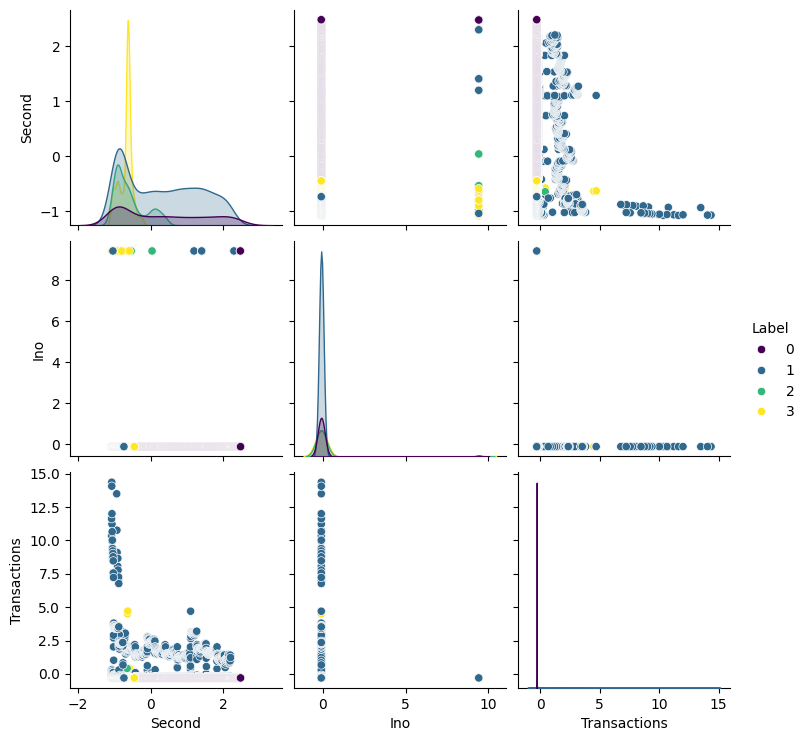

In [ ]:
sns.pairplot(df_normalized, hue='Label', palette='viridis')
plt.show()


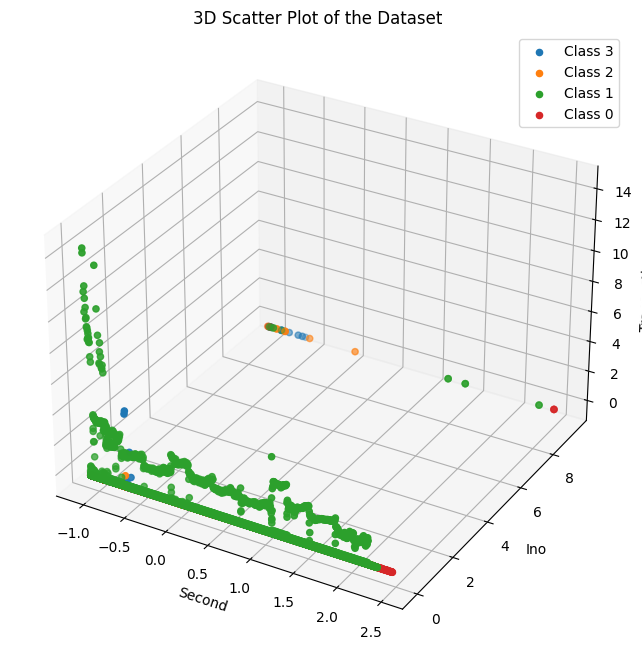

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for label in df_normalized['Label'].unique():
    data_class = df_normalized[df_normalized['Label'] == label]
    ax.scatter(data_class['Second'], data_class['Ino'], data_class['Transactions'], label=f'Class {label}')

ax.set_xlabel('Second')
ax.set_ylabel('Ino')
ax.set_zlabel('Transactions')
ax.set_title('3D Scatter Plot of the Dataset')
ax.legend()

plt.show()


# training without dim reduction using tree and nn

In [ ]:
X = df_normalized[['Second', 'Ino', 'Transactions']]
y = df_normalized['Label']

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

dt_model = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
nn_scores = cross_val_score(mlp_model, X, y, cv=cv, scoring='accuracy')
print("Neural Network Cross-Validation Accuracy: {:.2f}%".format(np.mean(nn_scores) * 100))


Neural Network Cross-Validation Accuracy: 60.73%


In [ ]:
dt_model.fit(X, y)
y_pred_dt = dt_model.predict(X)
accuracy_dt = accuracy_score(y, y_pred_dt)
print("Decision Tree Accuracy: {:.2f}%".format(accuracy_dt * 100))
print("Decision Tree Classification Report:\n", classification_report(y, y_pred_dt))

Decision Tree Accuracy: 74.13%
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.98      0.56       996
           1       0.99      0.77      0.86      3416
           2       0.83      0.56      0.67      1025
           3       0.98      0.62      0.76      1135

    accuracy                           0.74      6572
   macro avg       0.79      0.73      0.71      6572
weighted avg       0.87      0.74      0.77      6572



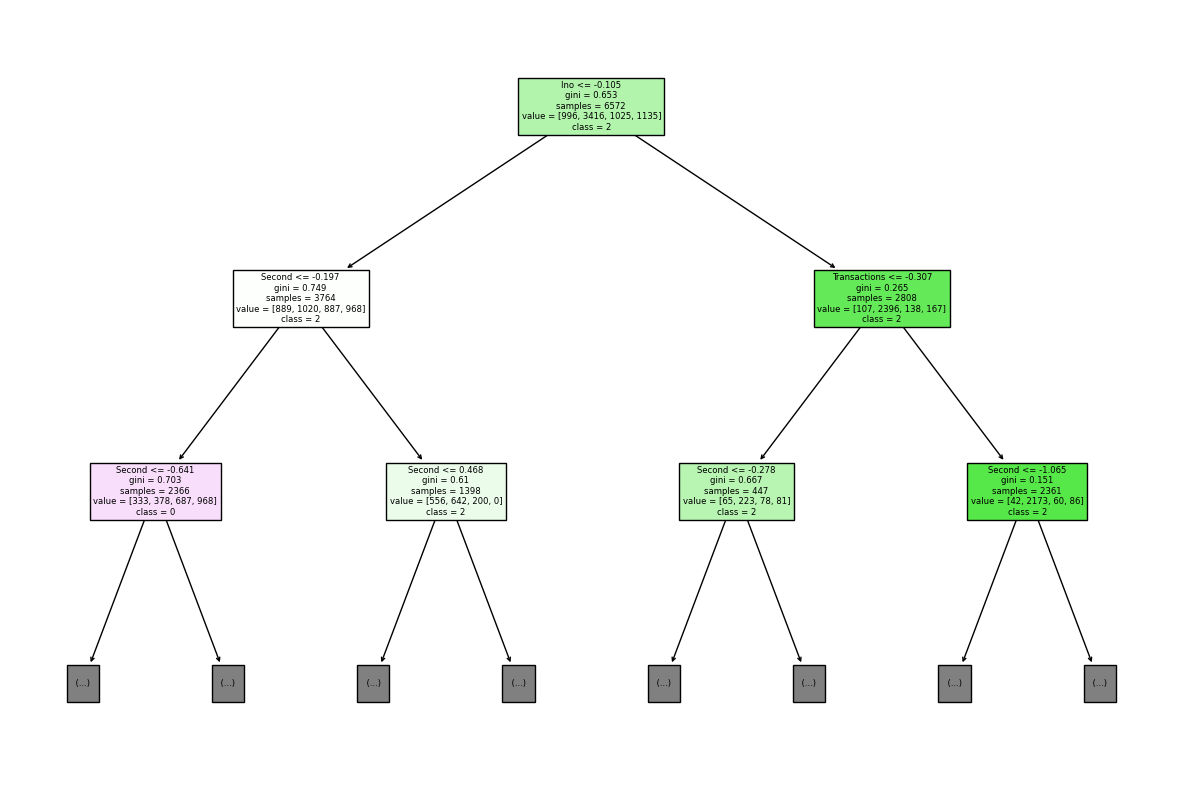

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=[str(label) for label in y.unique()], max_depth=2)
plt.show()


# Working with larger and bigger dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/AI/OS_lab

/content/drive/MyDrive/AI/OS_lab


In [ ]:
ls

Final-Data.csv


In [ ]:
dataset = pd.read_csv('Final-Data.csv')

In [ ]:
dataset

,time_elapsed,ino,state,flag,ops_per_sec,distance_from_mean,cumulative_time_elapsed,time_difference,workload_type
0,-0.187062,0.432535,-0.033807,-0.003553,0.603335,-0.187062,0.496030,-0.002248,4
1,-0.181245,-0.431407,-0.033807,-0.003554,-1.003513,-0.181245,-1.607346,0.004003,2
2,-0.187059,-0.431407,-0.033807,-0.003554,0.540562,-0.187059,0.417695,-0.006696,2
3,-0.187045,0.432535,-0.033807,-0.003553,0.345057,-0.187045,0.511771,-0.079333,4
4,-0.187096,-0.723851,-0.033807,-0.003553,1.553668,-0.187096,0.514653,-0.000118,4
...,...,...,...,...,...,...,...,...,...
1425427,-0.186935,0.432535,-0.033807,-0.003553,-0.345303,-0.186935,0.539052,0.000134,4
1425428,-0.184375,0.432535,-0.033807,-0.003553,-0.975072,-0.184375,0.538385,0.001783,4
1425429,-0.186925,0.432535,-0.033807,-0.003553,-0.375921,-0.186925,0.530154,0.000138,4
1425430,-0.185374,0.432535,-0.033807,-0.003553,-0.944959,-0.185374,0.489804,0.001102,4


In [ ]:
sample_fraction = 0.5
sampled_data = dataset.sample(frac=sample_fraction, random_state=42)
print("Shape of Sampled Data:", sampled_data.shape)
print("\nSampled Data Overview:")
print(sampled_data.head())


Shape of Sampled Data: (712716, 9)

Sampled Data Overview:
        time_elapsed       ino     state      flag  ops_per_sec  \
609434     -0.186918  0.432535 -0.033807 -0.003553    -0.397144   
43289      -0.186924  0.432535 -0.033807 -0.003553    -0.379040   
496397     -0.186910  0.432535 -0.033807 -0.003553    -0.417945   
14783      -0.184924  0.432535 -0.033807 -0.003553    -0.961859   
465916     -0.187101 -0.723851 -0.033807 -0.003553     1.785196   

        distance_from_mean  cumulative_time_elapsed  time_difference  \
609434           -0.186918                 0.504013         0.000142   
43289            -0.186924                 0.495346         0.000137   
496397           -0.186910                 0.504151         0.000145   
14783            -0.184924                 0.524942         0.001391   
465916           -0.187101                 0.534982         0.000015   

        workload_type  
609434              4  
43289               4  
496397              4  
14783    

In [ ]:
dataset = sampled_data

In [ ]:
X = dataset.drop('workload_type', axis=1)
y = dataset['workload_type']


trying to find out which feature to delete using random forest classifire

In [ ]:
model = RandomForestClassifier()
model.fit(X, y)


RandomForestClassifier()

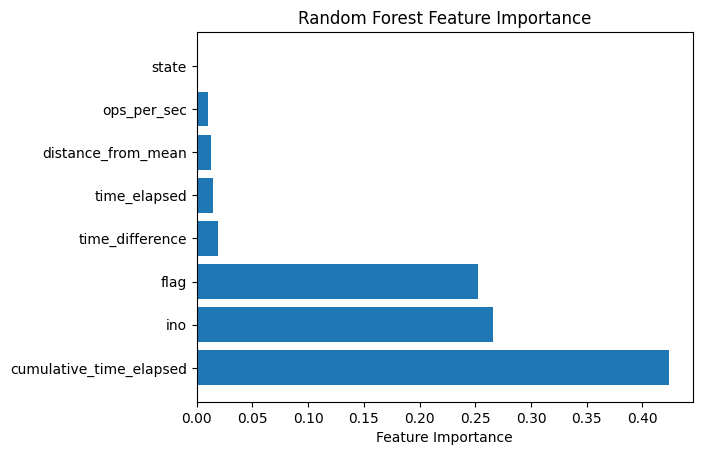

In [ ]:
feature_importances = model.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

plt.barh(range(len(sorted_features)), [val[1] for val in sorted_features], align='center')
plt.yticks(range(len(sorted_features)), [val[0] for val in sorted_features])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


removing non-important features

In [ ]:
threshold = 0.05
indices_to_keep = [i for i, importance in enumerate(feature_importances) if importance > threshold]
selected_features = X.iloc[:, indices_to_keep]


In [ ]:
X = selected_features
print("\nShape of Updated Features (X):", X.shape)
print("\nUpdated Features (X):")
print(X.head())
print("\nShape of Updated Features (X):", y.shape)
print("\nTarget Variable (y):")
print(y.head())


Shape of Updated Features (X): (712716, 3)

Updated Features (X):
             ino      flag  cumulative_time_elapsed
609434  0.432535 -0.003553                 0.504013
43289   0.432535 -0.003553                 0.495346
496397  0.432535 -0.003553                 0.504151
14783   0.432535 -0.003553                 0.524942
465916 -0.723851 -0.003553                 0.534982

Shape of Updated Features (X): (712716,)

Target Variable (y):
609434    4
43289     4
496397    4
14783     4
465916    4
Name: workload_type, dtype: int64


In [ ]:
X

,ino,flag,cumulative_time_elapsed
609434,0.432535,-0.003553,0.504013
43289,0.432535,-0.003553,0.495346
496397,0.432535,-0.003553,0.504151
14783,0.432535,-0.003553,0.524942
465916,-0.723851,-0.003553,0.534982
...,...,...,...
300532,0.432535,-0.003553,0.501257
300607,-0.431407,-0.003554,-0.638771
178789,0.432535,-0.003553,0.516897
585766,0.432535,-0.003553,0.489849


using T-SNE to visualize our data
once in 2-D 😆

In [ ]:
!pip install openTSNE


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.4 MB/s eta 0:00:00


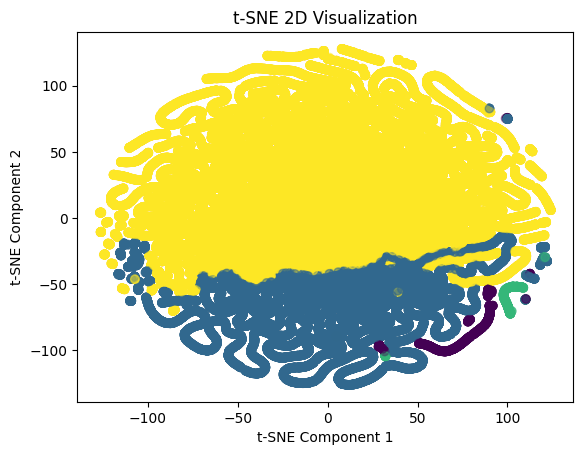

In [ ]:
X_data = selected_features.values

y_data = y.values
n_components_2d = 2
tsne_2d = TSNE(n_components=n_components_2d, random_state=40, n_jobs=-1)
X_tsne_2d = tsne_2d.fit(X_data)

plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_data, cmap='viridis', alpha=0.5)
plt.title('t-SNE 2D Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
index_to_class_mapping = {1: 'readseq', 2:'readrandom', 3: 'readreverse', 4: 'readrandomwriterandom'}



using MPL nn models

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

nn_accuracy = nn_model.score(X_test, y_test)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Neural Network Accuracy: 0.9979


creating a nn model from scratch using the sequentials

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_onehot = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

def create_nn_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

input_dim = X_train.shape[1]
output_dim = y_onehot.shape[1]
nn_model = create_nn_model(input_dim, output_dim)


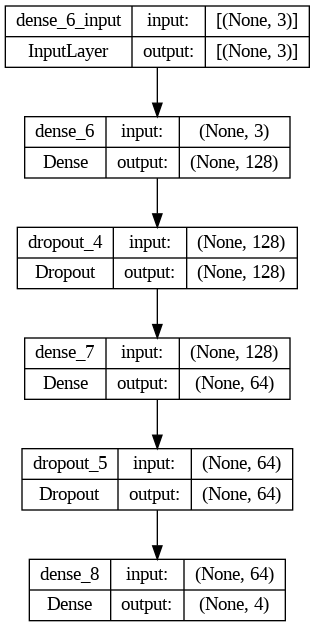

In [ ]:
plot_model(nn_model, to_file='neural_network_model.png', show_shapes=True, show_layer_names=True)


Epoch 1/20
8909/8909 - 31s - loss: 0.0692 - accuracy: 0.9784 - val_loss: 0.0334 - val_accuracy: 0.9834 - 31s/epoch - 3ms/step
Epoch 2/20
8909/8909 - 28s - loss: 0.0347 - accuracy: 0.9875 - val_loss: 0.0209 - val_accuracy: 0.9896 - 28s/epoch - 3ms/step
Epoch 3/20
8909/8909 - 28s - loss: 0.0357 - accuracy: 0.9902 - val_loss: 0.0187 - val_accuracy: 0.9925 - 28s/epoch - 3ms/step
Epoch 4/20
8909/8909 - 30s - loss: 0.0284 - accuracy: 0.9922 - val_loss: 0.0231 - val_accuracy: 0.9917 - 30s/epoch - 3ms/step
Epoch 5/20
8909/8909 - 30s - loss: 0.0219 - accuracy: 0.9926 - val_loss: 0.0165 - val_accuracy: 0.9942 - 30s/epoch - 3ms/step
Epoch 6/20
8909/8909 - 28s - loss: 0.0206 - accuracy: 0.9930 - val_loss: 0.0131 - val_accuracy: 0.9946 - 28s/epoch - 3ms/step
Epoch 7/20
8909/8909 - 28s - loss: 0.0228 - accuracy: 0.9931 - val_loss: 0.0124 - val_accuracy: 0.9967 - 28s/epoch - 3ms/step
Epoch 8/20
8909/8909 - 28s - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.0146 - val_accuracy: 0.9936 - 28s/epoch - 3

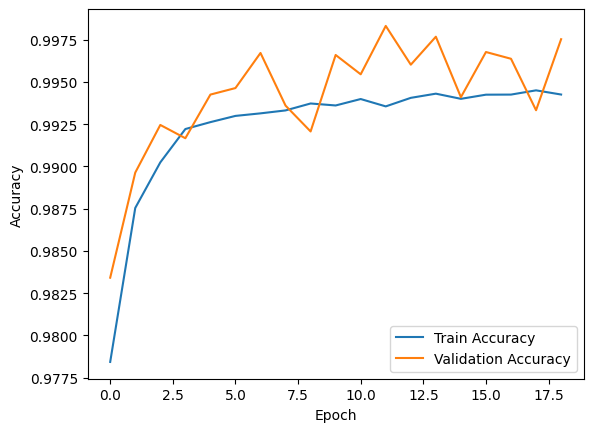

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = nn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
nn_predictions = nn_model.predict(X_test)

nn_predictions_indices = nn_predictions.argmax(axis=1)
y_test_indices = y_test.argmax(axis=1)

print("Neural Network Classification Report:")
print(classification_report(y_test_indices, nn_predictions_indices, target_names=index_to_class_mapping.values()))

4455/4455 [==============================] - 10s 2ms/step
Neural Network Classification Report:
                       precision    recall  f1-score   support

              readseq       1.00      0.94      0.97      1623
           readrandom       1.00      1.00      1.00     37962
          readreverse       0.86      0.81      0.83       698
readrandomwriterandom       1.00      1.00      1.00    102261

             accuracy                           1.00    142544
            macro avg       0.96      0.94      0.95    142544
         weighted avg       1.00      1.00      1.00    142544



Greattt resaults on NN models!! 🙂

let's try dt

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

dt_accuracy = dt_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")


Decision Tree Accuracy: 1.0000


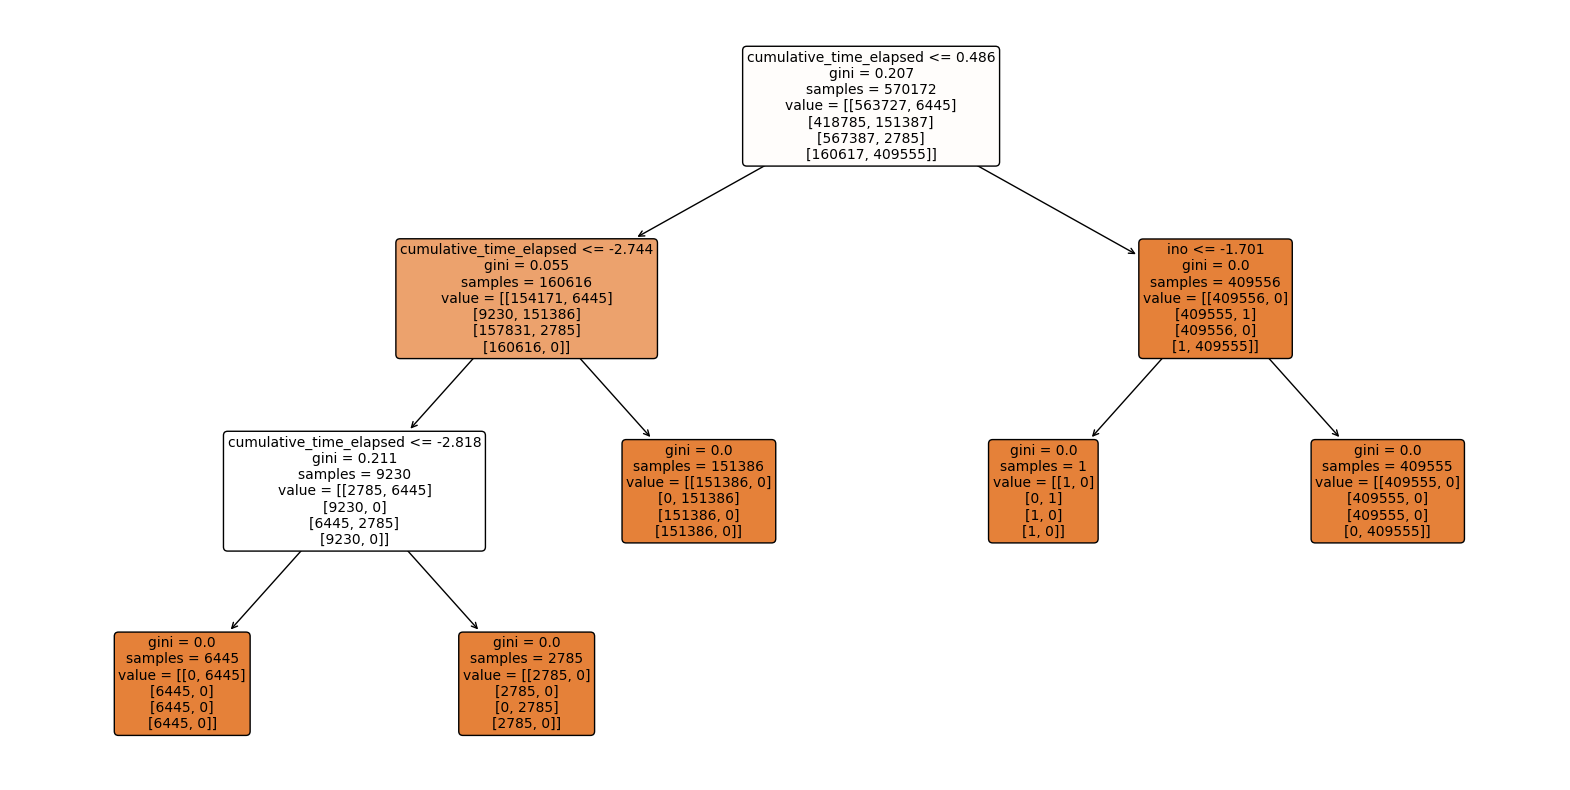

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=index_to_class_mapping.values(), rounded=True, fontsize=10)
plt.show()


In [ ]:
dt_predictions = dt_model.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_predictions, target_names=index_to_class_mapping.values()))

Decision Tree Classification Report:
                       precision    recall  f1-score   support

              readseq       1.00      1.00      1.00      1623
           readrandom       1.00      1.00      1.00     37962
          readreverse       1.00      1.00      1.00       698
readrandomwriterandom       1.00      1.00      1.00    102261

            micro avg       1.00      1.00      1.00    142544
            macro avg       1.00      1.00      1.00    142544
         weighted avg       1.00      1.00      1.00    142544
          samples avg       1.00      1.00      1.00    142544



**Awesome!** 🆙

***Let's use Random forrest too***

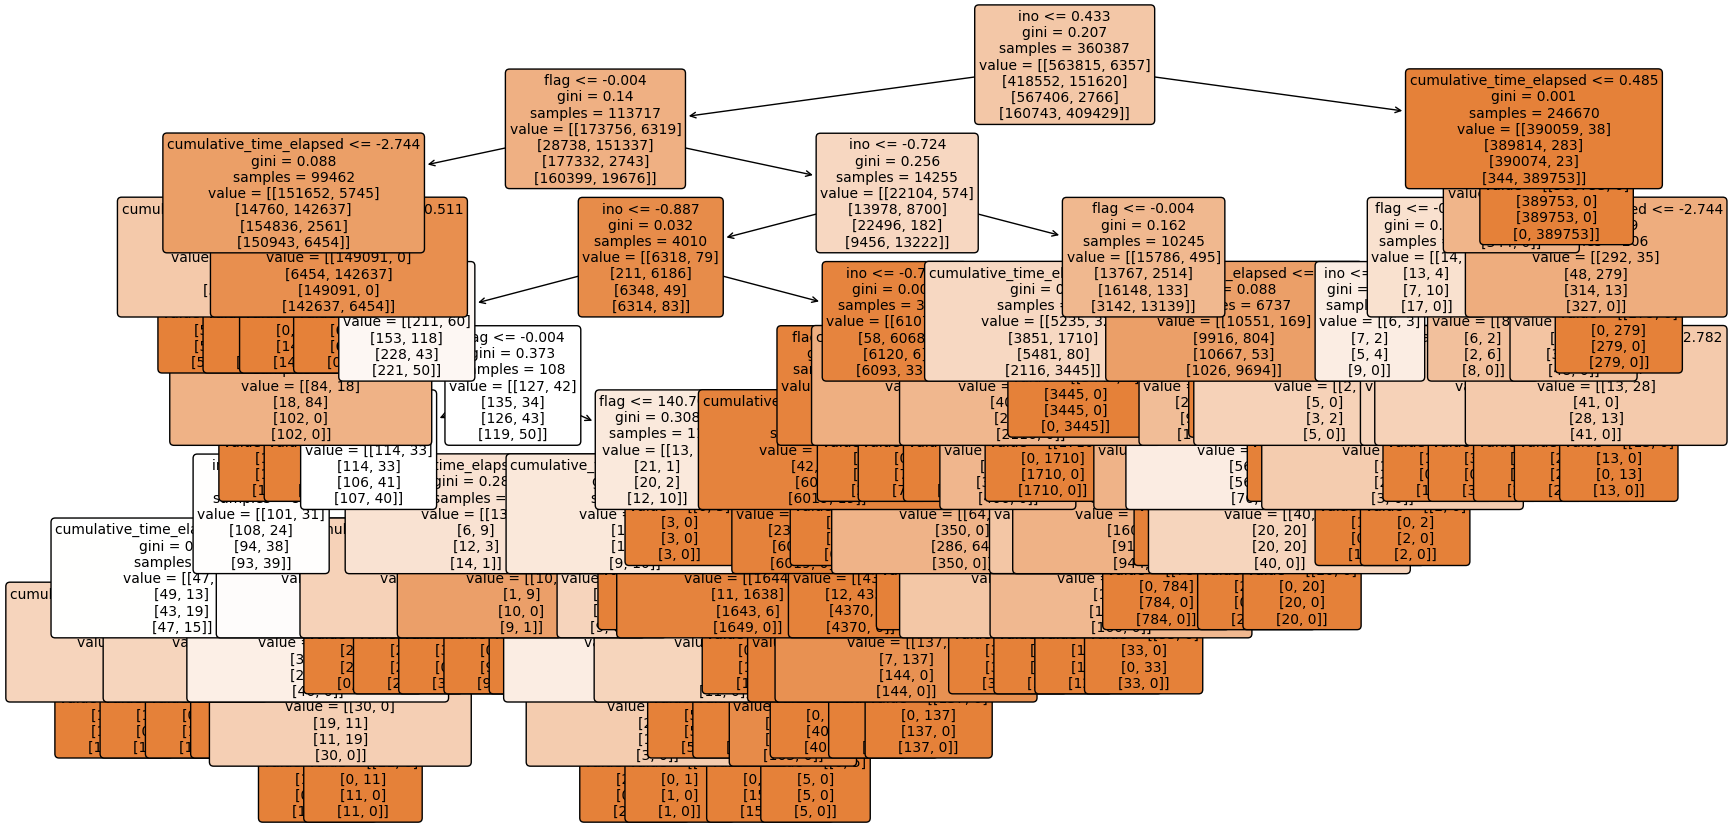

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
selected_tree = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(selected_tree, filled=True, feature_names=X.columns, class_names=index_to_class_mapping.values(), rounded=True, fontsize=10)
plt.show()


as you see there are lots of trees for making the decision. That's why it is called Random Forrest! **🙂**

In [ ]:
from sklearn.metrics import classification_report

rf_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test.argmax(axis=1), rf_predictions.argmax(axis=1), target_names=index_to_class_mapping.values()))


Random Forest Accuracy: 1.0000
Random Forest Classification Report:
                       precision    recall  f1-score   support

              readseq       1.00      1.00      1.00      1623
           readrandom       1.00      1.00      1.00     37962
          readreverse       1.00      1.00      1.00       698
readrandomwriterandom       1.00      1.00      1.00    102261

             accuracy                           1.00    142544
            macro avg       1.00      1.00      1.00    142544
         weighted avg       1.00      1.00      1.00    142544

